* Primitives: ['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity']
* [Kaggle Run](https://www.kaggle.com/code/naresh/amoebanet?scriptVersionId=111345601)
* Best Accuracy: 78.06%
* Best Configuration:

|Block|Normal|Reduction|
|:-:|-|-|
|1.|`[1 1 0 1 0]`|`[0 0 4 2 0]`|
|2.|`[1 1 4 1 0]`|`[1 0 4 3 0]`|
|3.|`[0 0 0 5 1]`|`[1 1 1 2 1]`|
|4.|`[0 1 0 1 1]`|`[0 0 4 5 1]`|
|5.|`[0 0 0 5 1]`|`[0 1 1 4 0]`|


<!--
[[[1 1 0 1 0]
  [1 1 4 1 0]
  [0 0 0 5 1]
  [0 1 0 1 1]
  [0 0 0 5 1]]

 [[0 0 4 2 0]
  [1 0 4 3 0]
  [1 1 1 2 1]
  [0 0 4 5 1]
  [0 1 1 4 0]]]
-->

<img src='amoeba.v1.best.cells.png' width='75%'/>

## Import Modules used in this Notebook

In [2]:
%%capture

import random

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses, models, optimizers
from matplotlib import pyplot as plt
from matplotlib import ticker
from collections import deque
from random import sample, shuffle, randrange
from math import floor
from functools import reduce

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Dataset Setup

In [3]:
%%capture
# DATASET = 'mnist'
DATASET = 'cifar10'
TRAIN_BATCH_SIZE = 128

if DATASET == 'mnist':
    DATASET_PARAMS = dict(
        input_shape=(28, 28, 3),
        n_classes=10,
        baseline_accuracy=.3,
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

    gray_to_rgb = lambda image, label: (tf.repeat(image, 3, axis=-1), label)
    train_ds = train_ds.map(gray_to_rgb)
    val_ds = val_ds.map(gray_to_rgb)
elif DATASET == 'cifar10':
    DATASET_PARAMS = dict(
        input_shape=(32, 32, 3),
        n_classes=10,
        baseline_accuracy=.1,
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

# Hack to run on Kaggle
TDS = train_ds.shuffle(
    500,
    reshuffle_each_iteration=True
).batch(TRAIN_BATCH_SIZE)
VDS = val_ds.batch(256)

for item in TDS: pass
for item in VDS: pass

2022-11-18 05:24:47.848874: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2022-11-18 05:24:55.478268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 05:24:55.578909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 05:24:55.579635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

NameError: name 'CHILD_PARAMS' is not defined

2022-11-18 05:25:54.893483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-18 05:25:54.947818: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


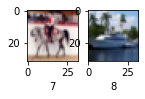

In [4]:
def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, item in enumerate(display_list):
        image, label = item
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))
        axis.set_xlabel(label)

items = []
for item in train_ds.take(2).as_numpy_iterator():
    items.append(item)

display(items, size=(2,2))

## Architecture Search

In [5]:
CHILD_PARAMS = dict(
    epochs=7,
    batch_size=TRAIN_BATCH_SIZE,
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
#         values=['sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]

TDS = CHILD_PARAMS['train_ds'].shuffle(
    500,
    reshuffle_each_iteration=True
).batch(CHILD_PARAMS['batch_size'])
VDS = CHILD_PARAMS['val_ds'].batch(256)

class CNNCell():
    """
    It composes a cell based on the input configuration.
    Arguments:
        stride: A positive integer to represent the convolution strides.
            Normal cells use stride=1 and reduction cells use stride=2
    """
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
        """
        This method sends the input through a convolution layer with
        a fixed channel size to ensure that the inputs to each cell block
        have identical channel dimensions.
        """
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
        """
        It transforms the input branches to an identical feature space.
        It is useful when a cell receives inputs with different feature spaces.
        """
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
        """
        It halves the input feature space using a convolution layer with stride 2
        """
        if self.stride == 2:
            inputs = list(
                map(
                    lambda inp: layers.Conv2D(
                        self.channels,
                        3,
                        strides=(2,2),
                        padding='same'
                    )(inp),
                    inputs
                )
            )
        
        return inputs
    
    def apply_op(self, op_id, inp):
        """
        It applies a primitive operation to the input.
        """
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        """
        It applies a combination operation to the inputs.
        """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
        """
        It constructs a cell based on the cell_config and the branches.
        A cell_config is 2-D numpy array of shape [5,5] which contains
        the 5 state choices for each of the 5 blocks.
        """
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class Child(object):
    def __init__(self, config, train=True):
        self.config = config
        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]
        self.model = self.make_child()
        self.accuracy = 0.0
        self.accuracy = self.train() if train else 0
        print('Child: {} \n Accuracy: {:1.4f}'.format(
            self.config,
            self.accuracy
        ))
    
    def make_child(self):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(self.config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        # model.summary()

        return model

    def train(self):
        history = self.model.fit(
            TDS,
            validation_data=VDS,
            epochs=CHILD_PARAMS['epochs']
        )
        self.accuracy = max(history.history['val_accuracy'])

        return self.accuracy


CONTROLLER_PARAMS = dict(
    episodes=80,
    population_size=20,
    sample_size=12,
    mutation_size=2
)

BLOCK_TIMESTEPS = 5
CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self):
        self.population_size = CONTROLLER_PARAMS['population_size']
        self.population = deque(maxlen=self.population_size)
        self.histories = []
        self.sample_size = CONTROLLER_PARAMS['sample_size']
        self.best_accuracies = []
    
    def random_state(self, address):
        (_, __, state_id) = address
        return randrange(len(STATE_SPACE[state_id]['values']))

    def create_random_child(self):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)
        child = Child(config)
        return child

    def initialize_population(self):
        """
        It creates children as specified through the size parameter.
        Each child is trained and their history is stored.
        It should be called only once.

        Arguments:
            size: The size of the population.
        """
        def work_fn():
            self.population.extend(map(
                lambda _: self.create_random_child(),
                range(self.sample_size)
            ))
            self.histories += self.population
        
        work_fn() if not self.population else None
    
    def mutate(self, config):
        def mutate_once():
            mutation_address = tuple(map(randrange, TIMESTEP_ADDRESS_SPACE))
            state_id = mutation_address[-1]
            state_space_id = STATE_ID_TO_STATE_SPACE_ID[state_id]
            mutation = randrange(len(STATE_SPACE[state_space_id]['values']))

            return mutation_address, mutation

        def apply_mutation(config):
            address, mutation = mutate_once()
            print(address, mutation)
            config[address] = mutation
            return config
    
        mutated_config = reduce(
            lambda x,_: apply_mutation(x),
            range(2),
            config.copy())

        return mutated_config
    
    def run_cycle(self):
        # Pick random children from the population for the mutation stage
        p_sample = sample(range(len(self.population)), self.sample_size)

        # Find the best child in the sample
        sample_accuracies = list(map(
            lambda idx: self.population[idx].accuracy,
            p_sample
        ))
        best_sample = np.argmax(sample_accuracies)
        print('Best Child: {:2d} Accuracy: {:4f}'.format(
            p_sample[best_sample],
            sample_accuracies[best_sample]
        ))

        # Record the best accuracies
        population_accuracies = list(map(
            lambda item: item.accuracy,
            self.population
        ))
        self.best_accuracies.append(max(population_accuracies))

        # Mutate the best child in the sample
        best_child = self.population[p_sample[best_sample]]
        mutated_child = Child(self.mutate(best_child.config))

        # Update population
        print('Removal Candidate: {}\n Accuracy: {:1.5f}'.format(
            self.population[0].config,
            self.population[0].accuracy
        ))
        print('Mutation Candidate: {}\n Accuracy: {:1.5f}'.format(
            best_child.config,
            best_child.accuracy
        ))
        self.population.append(mutated_child)
                
        # Add the mutated child to the histories
        self.histories.append(mutated_child)

controller = Controller()
controller.initialize_population()

for episode in range(CONTROLLER_PARAMS['episodes']):
    print('Cycle: ', episode)
    controller.run_cycle()

Epoch 1/7


2022-11-18 05:25:58.941637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  3/313 [..............................] - ETA: 31s - loss: 8.2646 - accuracy: 0.1042

  5/313 [..............................] - ETA: 29s - loss: 7.9111 - accuracy: 0.1016

  7/313 [..............................] - ETA: 27s - loss: 6.9558 - accuracy: 0.1038

 10/313 [..............................] - ETA: 25s - loss: 5.8685 - accuracy: 0.1102

 13/313 [>.............................] - ETA: 24s - loss: 5.1890 - accuracy: 0.1142

 16/313 [>.............................] - ETA: 24s - loss: 4.7676 - accuracy: 0.1211

 18/313 [>.............................] - ETA: 23s - loss: 4.5223 - accuracy: 0.1285

 21/313 [=>............................] - ETA: 23s - loss: 4.2139 - accuracy: 0.1332

 23/313 [=>............................] - ETA: 24s - loss: 4.0542 - accuracy: 0.1321

 25/313 [=>............................] - ETA: 24s - loss: 3.9022 - accuracy: 0.1356

 27/313 [=>............................] - ETA: 24s - loss: 3.7741 - accuracy: 0.1377

 29/313 [=>............................] - ETA: 24s - loss: 3.6630 - accuracy: 0.1417

 32/313 [==>...........................] - ETA: 24s - loss: 3.5205 - accuracy: 0.1458

 34/313 [==>...........................] - ETA: 24s - loss: 3.4383 - accuracy: 0.1498

 37/313 [==>...........................] - ETA: 23s - loss: 3.3278 - accuracy: 0.1567

 39/313 [==>...........................] - ETA: 23s - loss: 3.2674 - accuracy: 0.1581

 42/313 [===>..........................] - ETA: 22s - loss: 3.1848 - accuracy: 0.1618

 45/313 [===>..........................] - ETA: 22s - loss: 3.1150 - accuracy: 0.1648

 48/313 [===>..........................] - ETA: 22s - loss: 3.0483 - accuracy: 0.1699

 50/313 [===>..........................] - ETA: 21s - loss: 3.0085 - accuracy: 0.1722

 53/313 [====>.........................] - ETA: 21s - loss: 2.9529 - accuracy: 0.1773

 56/313 [====>.........................] - ETA: 21s - loss: 2.9027 - accuracy: 0.1829

 59/313 [====>.........................] - ETA: 20s - loss: 2.8610 - accuracy: 0.1862

 62/313 [====>.........................] - ETA: 20s - loss: 2.8226 - accuracy: 0.1890

 65/313 [=====>........................] - ETA: 20s - loss: 2.7878 - accuracy: 0.1913

 68/313 [=====>........................] - ETA: 20s - loss: 2.7507 - accuracy: 0.1951

 71/313 [=====>........................] - ETA: 19s - loss: 2.7228 - accuracy: 0.1967

 74/313 [======>.......................] - ETA: 19s - loss: 2.6925 - accuracy: 0.2002

 76/313 [======>.......................] - ETA: 19s - loss: 2.6752 - accuracy: 0.2025

 79/313 [======>.......................] - ETA: 19s - loss: 2.6494 - accuracy: 0.2055

 81/313 [======>.......................] - ETA: 19s - loss: 2.6316 - accuracy: 0.2077

 83/313 [======>.......................] - ETA: 18s - loss: 2.6179 - accuracy: 0.2085

 86/313 [=======>......................] - ETA: 18s - loss: 2.5941 - accuracy: 0.2111

 89/313 [=======>......................] - ETA: 18s - loss: 2.5735 - accuracy: 0.2117

 92/313 [=======>......................] - ETA: 17s - loss: 2.5549 - accuracy: 0.2127

 94/313 [========>.....................] - ETA: 17s - loss: 2.5422 - accuracy: 0.2145

 97/313 [========>.....................] - ETA: 17s - loss: 2.5243 - accuracy: 0.2154

 99/313 [========>.....................] - ETA: 17s - loss: 2.5109 - accuracy: 0.2177

101/313 [========>.....................] - ETA: 17s - loss: 2.5016 - accuracy: 0.2188

105/313 [=========>....................] - ETA: 16s - loss: 2.4804 - accuracy: 0.2218

107/313 [=========>....................] - ETA: 16s - loss: 2.4718 - accuracy: 0.2226

110/313 [=========>....................] - ETA: 16s - loss: 2.4575 - accuracy: 0.2228

112/313 [=========>....................] - ETA: 16s - loss: 2.4483 - accuracy: 0.2236

115/313 [==========>...................] - ETA: 16s - loss: 2.4339 - accuracy: 0.2257

118/313 [==========>...................] - ETA: 15s - loss: 2.4227 - accuracy: 0.2272

121/313 [==========>...................] - ETA: 15s - loss: 2.4102 - accuracy: 0.2282

124/313 [==========>...................] - ETA: 15s - loss: 2.3977 - accuracy: 0.2300

127/313 [===========>..................] - ETA: 15s - loss: 2.3860 - accuracy: 0.2311

129/313 [===========>..................] - ETA: 14s - loss: 2.3787 - accuracy: 0.2313

132/313 [===========>..................] - ETA: 14s - loss: 2.3662 - accuracy: 0.2327

136/313 [============>.................] - ETA: 14s - loss: 2.3515 - accuracy: 0.2351

138/313 [============>.................] - ETA: 14s - loss: 2.3446 - accuracy: 0.2358

141/313 [============>.................] - ETA: 13s - loss: 2.3348 - accuracy: 0.2373

144/313 [============>.................] - ETA: 13s - loss: 2.3256 - accuracy: 0.2389

147/313 [=============>................] - ETA: 13s - loss: 2.3168 - accuracy: 0.2403

150/313 [=============>................] - ETA: 12s - loss: 2.3076 - accuracy: 0.2411

153/313 [=============>................] - ETA: 12s - loss: 2.2996 - accuracy: 0.2422

156/313 [=============>................] - ETA: 12s - loss: 2.2902 - accuracy: 0.2434

159/313 [==============>...............] - ETA: 12s - loss: 2.2825 - accuracy: 0.2438

162/313 [==============>...............] - ETA: 11s - loss: 2.2744 - accuracy: 0.2454

165/313 [==============>...............] - ETA: 11s - loss: 2.2671 - accuracy: 0.2469

168/313 [===============>..............] - ETA: 11s - loss: 2.2609 - accuracy: 0.2473

170/313 [===============>..............] - ETA: 11s - loss: 2.2562 - accuracy: 0.2481

174/313 [===============>..............] - ETA: 10s - loss: 2.2458 - accuracy: 0.2491

176/313 [===============>..............] - ETA: 10s - loss: 2.2413 - accuracy: 0.2497

179/313 [================>.............] - ETA: 10s - loss: 2.2337 - accuracy: 0.2513

182/313 [================>.............] - ETA: 10s - loss: 2.2252 - accuracy: 0.2529

184/313 [================>.............] - ETA: 10s - loss: 2.2212 - accuracy: 0.2532

187/313 [================>.............] - ETA: 9s - loss: 2.2150 - accuracy: 0.2546

190/313 [=================>............] - ETA: 9s - loss: 2.2082 - accuracy: 0.2558

193/313 [=================>............] - ETA: 9s - loss: 2.2027 - accuracy: 0.2563

195/313 [=================>............] - ETA: 9s - loss: 2.1989 - accuracy: 0.2571

198/313 [=================>............] - ETA: 9s - loss: 2.1939 - accuracy: 0.2576

201/313 [==================>...........] - ETA: 8s - loss: 2.1882 - accuracy: 0.2585

204/313 [==================>...........] - ETA: 8s - loss: 2.1827 - accuracy: 0.2598

207/313 [==================>...........] - ETA: 8s - loss: 2.1777 - accuracy: 0.2605

210/313 [===================>..........] - ETA: 8s - loss: 2.1717 - accuracy: 0.2617

213/313 [===================>..........] - ETA: 7s - loss: 2.1661 - accuracy: 0.2624

216/313 [===================>..........] - ETA: 7s - loss: 2.1604 - accuracy: 0.2634

219/313 [===================>..........] - ETA: 7s - loss: 2.1542 - accuracy: 0.2644

221/313 [====================>.........] - ETA: 7s - loss: 2.1510 - accuracy: 0.2651

224/313 [====================>.........] - ETA: 6s - loss: 2.1457 - accuracy: 0.2662

227/313 [====================>.........] - ETA: 6s - loss: 2.1407 - accuracy: 0.2668

229/313 [====================>.........] - ETA: 6s - loss: 2.1378 - accuracy: 0.2671

232/313 [=====================>........] - ETA: 6s - loss: 2.1317 - accuracy: 0.2682

234/313 [=====================>........] - ETA: 6s - loss: 2.1281 - accuracy: 0.2690

237/313 [=====================>........] - ETA: 5s - loss: 2.1223 - accuracy: 0.2703

240/313 [======================>.......] - ETA: 5s - loss: 2.1158 - accuracy: 0.2718

243/313 [======================>.......] - ETA: 5s - loss: 2.1106 - accuracy: 0.2729

246/313 [======================>.......] - ETA: 5s - loss: 2.1050 - accuracy: 0.2739

249/313 [======================>.......] - ETA: 4s - loss: 2.1008 - accuracy: 0.2746

252/313 [=======================>......] - ETA: 4s - loss: 2.0965 - accuracy: 0.2755

255/313 [=======================>......] - ETA: 4s - loss: 2.0922 - accuracy: 0.2764

258/313 [=======================>......] - ETA: 4s - loss: 2.0881 - accuracy: 0.2766

261/313 [========================>.....] - ETA: 4s - loss: 2.0835 - accuracy: 0.2777

264/313 [========================>.....] - ETA: 3s - loss: 2.0787 - accuracy: 0.2787

266/313 [========================>.....] - ETA: 3s - loss: 2.0758 - accuracy: 0.2796

270/313 [========================>.....] - ETA: 3s - loss: 2.0701 - accuracy: 0.2810

273/313 [=========================>....] - ETA: 3s - loss: 2.0661 - accuracy: 0.2821

276/313 [=========================>....] - ETA: 2s - loss: 2.0627 - accuracy: 0.2829

279/313 [=========================>....] - ETA: 2s - loss: 2.0593 - accuracy: 0.2838

281/313 [=========================>....] - ETA: 2s - loss: 2.0567 - accuracy: 0.2844

284/313 [==========================>...] - ETA: 2s - loss: 2.0531 - accuracy: 0.2850

286/313 [==========================>...] - ETA: 2s - loss: 2.0506 - accuracy: 0.2856

289/313 [==========================>...] - ETA: 1s - loss: 2.0464 - accuracy: 0.2866

292/313 [==========================>...] - ETA: 1s - loss: 2.0432 - accuracy: 0.2870

295/313 [===========================>..] - ETA: 1s - loss: 2.0394 - accuracy: 0.2882

298/313 [===========================>..] - ETA: 1s - loss: 2.0354 - accuracy: 0.2887

300/313 [===========================>..] - ETA: 1s - loss: 2.0336 - accuracy: 0.2891

303/313 [============================>.] - ETA: 0s - loss: 2.0306 - accuracy: 0.2898

307/313 [============================>.] - ETA: 0s - loss: 2.0270 - accuracy: 0.2906

313/313 [==============================] - ETA: 0s - loss: 2.0208 - accuracy: 0.2919

313/313 [==============================] - 48s 123ms/step - loss: 2.0208 - accuracy: 0.2919 - val_loss: 1.6998 - val_accuracy: 0.3755


Epoch 2/7
313/313 [==============================] - 26s 81ms/step - loss: 1.5653 - accuracy: 0.4299 - val_loss: 1.4344 - val_accuracy: 0.4747
Epoch 3/7
313/313 [==============================] - 25s 81ms/step - loss: 1.3690 - accuracy: 0.5113 - val_loss: 1.2958 - val_accuracy: 0.5404
Epoch 4/7
313/313 [==============================] - 26s 82ms/step - loss: 1.2448 - accuracy: 0.5634 - val_loss: 1.1571 - val_accuracy: 0.5899
Epoch 5/7
313/313 [==============================] - 26s 82ms/step - loss: 1.1422 - accuracy: 0.6028 - val_loss: 1.0732 - val_accuracy: 0.6338
Epoch 6/7
313/313 [==============================] - 26s 82ms/step - loss: 1.0748 - accuracy: 0.6248 - val_loss: 0.9915 - val_accuracy: 0.6544
Epoch 7/7
313/313 [==============================] - 26s 82ms/step - loss: 1.0050 - accuracy: 0.6524 - val_loss: 0.9477 - val_accuracy: 0.6744
Child: [[[0 0 5 3 0]
  [0 1 3 3 1]
  [1 0 5 5 1]
  [1 0 2 5 0]
  [1 1 0 3 0]]

 [[1 0 2 3 0]
  [1 0 4 0 0]
  [1 1 5 3 1]
  [1 0 5 5 0]
  [0 0 

## Training Metrics

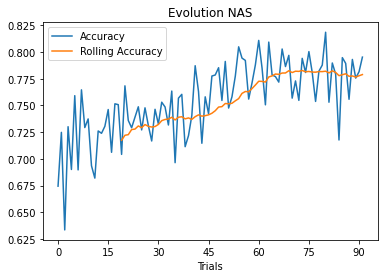

In [6]:
accuracies = list(map(lambda child: child.accuracy, controller.histories))
accuracies_df = pd.DataFrame(accuracies)
rolling_accuracies = accuracies_df.rolling(len(controller.population)).mean()[0].tolist()

plt.plot(accuracies, label='Accuracy')
axes = plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Trials')
plt.legend()
plt.title('Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

## Performance Analysis

[0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7646499872207642,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7684000134468079,
 0.7634999752044678,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7872499823570251,
 0.7912499904632568,
 0.7912499904632568,
 0.7912499904632568,
 0.7912499904632568,
 0.8049499988555908,
 0.8049499988555908,
 0.8049499988555908,
 0.8049499988555908,
 0.8049499988

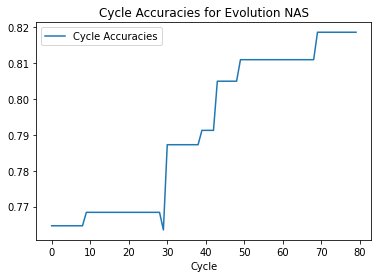

In [7]:
plt.plot(controller.best_accuracies, label='Cycle Accuracies')
plt.xlabel('Cycle')
plt.legend()
plt.title('Cycle Accuracies for Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

controller.best_accuracies